# Comparison of the four trained models

The following notebook has been used to generate the comparison image found in the report

# Imports and helper functions

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import wandb
from model import TextureSynthesizer

In [122]:
def plot_images(images, labels, num_images=6):

    fig, axes = plt.subplots(2, 3, figsize=(5, 3))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i in range(2):
        for j in range(3):
            idx = i * 3 + j
            if idx < num_images:
                axes[i, j].imshow(images[idx], cmap="hot")
                axes[i, j].set_title(labels[idx], fontsize=10)
                axes[i, j].axis('off')

    for i in range(num_images, 6):
        axes[i // 3, i % 3].axis('off')

    plt.tight_layout()
    plt.show()


In [123]:
import torch
import os
from torch.utils.data import DataLoader, Dataset

x_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

y_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])


class PairedImageDataset(Dataset):
    def __init__(self, sample_dir, ground_truth_dir, percentage, x_transform=None, filter_indices=None, y_transform=None):

        self.sample_files = self.get_image_files(sample_dir)
        self.ground_truth_files = self.get_image_files(ground_truth_dir)

        if percentage <= 0 or percentage > 100:
            raise ValueError("Percentages should be between 0 and 100")

        num_samples = int(len(self.sample_files) * (percentage / 100))

        if filter_indices is not None:
            samples = set(range(len(self.sample_files))) - set(filter_indices)
            indices = random.sample(list(samples), num_samples)
        else:
            indices = random.sample(range(len(self.sample_files)), num_samples)

        self.indices = indices

        self.sample_files = [self.sample_files[i] for i in indices]
        self.ground_truth_files = [self.ground_truth_files[i] for i in indices]

        self.x_transform = x_transform
        self.y_transform = y_transform

    def __getitem__(self, index):

        sample_file = self.sample_files[index]
        ground_truth_file = self.ground_truth_files[index]

        sample_image = self.load_image(sample_file)
        ground_truth_image = self.load_image(ground_truth_file)

        if self.x_transform is not None:
            sample_image = self.x_transform(sample_image)
        if self.y_transform is not None:
            ground_truth_image = self.y_transform(ground_truth_image)

        return sample_image, ground_truth_image

    def __len__(self):
        return len(self.sample_files)

    def get_image_files(self, directory):
        image_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if self.is_image_file(file):
                    image_files.append(os.path.join(root, file))
        return image_files

    def is_image_file(self, filename):
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
        return any(filename.lower().endswith(ext) for ext in image_extensions)

    def load_image(self, file):
        with Image.open(file) as img:
            return img.convert("RGB")
        
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
SAMPLE_DIR = "./dataset/textures-label/x"
GROUND_TRUTH_DIR = "./dataset/textures-label/y"
TRAIN_PERCENTAGE = 20
TEST_PERCENTAGE = 5
NUM_EPOCHS=1

train_dataset = PairedImageDataset(GROUND_TRUTH_DIR, GROUND_TRUTH_DIR, TRAIN_PERCENTAGE, x_transform=x_transform, y_transform=y_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = PairedImageDataset(GROUND_TRUTH_DIR, GROUND_TRUTH_DIR, TEST_PERCENTAGE, x_transform=x_transform, y_transform=y_transform, filter_indices=train_dataset.indices)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Loading the models

#### Downloading the model artifacts

In [124]:
api = wandb.Api()

# VGG Encoder + Gram
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v4')
artifact.download()

# NVIDIA Encoder + Gram
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v1')
artifact.download()

# VGG Encoder + Wasserstein
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v5')
artifact.download()

# NVIDIA Encoder + Wasserstein 
artifact = api.artifact('antox9/dlai-texture-synthesis/model:v3')
artifact.download()

wandb: Downloading large artifact model:v4, 426.11MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact model:v1, 419.52MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact model:v5, 426.11MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact model:v3, 419.52MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1


'./artifacts/model:v3'

#### Models initialization

In [125]:
def get_dict(path):
    state_dict = torch.load(path)
    state_dict_copy = dict(state_dict)
    for key in state_dict.keys():   # iter on both keys and values
        if key.startswith('fid.inception') or key.startswith('vgg.features'):
            state_dict_copy.pop(key, None)
    return state_dict_copy

In [126]:
dict_vgg_enc_gram = get_dict("artifacts/model:v4/model_weights_599.pth")
dict_nvidia_enc_gram = get_dict("artifacts/model:v1/model_weights_599.pth")
dict_nvidia_enc_wasserstein = get_dict("artifacts/model:v3/model_weights_599.pth")
dict_vgg_enc_wasserstein = get_dict("artifacts/model:v5/model_weights_599.pth")

In [127]:
model_vgg_enc_gram = TextureSynthesizer(64, 64, encoder_type="vgg").to(device="cuda")
model_nvidia_enc_gram = TextureSynthesizer(64, 64, encoder_type="default").to(device="cuda")
model_nvidia_enc_wasserstein = TextureSynthesizer(64, 64, encoder_type="default").to(device="cuda")
model_vgg_enc_wasserstein = TextureSynthesizer(64, 64, encoder_type="vgg").to(device="cuda")

/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [128]:
model_vgg_enc_gram.load_state_dict(dict_vgg_enc_gram)
model_nvidia_enc_gram.load_state_dict(dict_nvidia_enc_gram)
model_nvidia_enc_wasserstein.load_state_dict(dict_nvidia_enc_wasserstein)
model_vgg_enc_wasserstein.load_state_dict(dict_vgg_enc_wasserstein)

model_vgg_enc_gram.eval()
model_nvidia_enc_gram.eval()
model_nvidia_enc_wasserstein.eval()
model_vgg_enc_wasserstein.eval()

TextureSynthesizer(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

## Comparison

#### Forward passes

In [129]:
models = [model_vgg_enc_gram, model_nvidia_enc_gram, model_nvidia_enc_wasserstein, model_vgg_enc_wasserstein]

In [130]:
from PIL import Image
test = Image.open("test.png").convert('RGB')

In [131]:
from torchvision import transforms
x_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

x = x_transform(test).unsqueeze(0).to(device="cuda")

In [132]:
y_batch = [model(x).squeeze(0).detach().cpu().permute(1,2,0).numpy() for model in models]

/home/antonio/miniconda3/envs/dlai-env/lib/python3.11/site-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


#### Final comparison

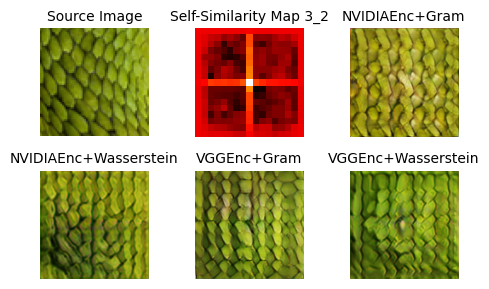

In [133]:
image_shape = (256, 256, 3)
num_images = 6

images = [np.random.randint(0, 256, size=image_shape, dtype=np.uint8) for _ in range(num_images)]
labels = ["Source Image", "Self-Similarity Map 3_2", "NVIDIAEnc+Gram", "NVIDIAEnc+Wasserstein", "VGGEnc+Gram", "VGGEnc+Wasserstein"]


ssl_1, ssl_2, ssl_3 = model_nvidia_enc_gram.get_self_similarity(x)

self_sim_maps =[ img.squeeze(0).detach().cpu().permute(1,2,0).numpy()  for img in [ssl_1, ssl_2, ssl_3] ]

images[0] = test
images[1] =  self_sim_maps[2]

images[2]  = y_batch[1]
images[5] = y_batch[3]
images[4] = y_batch[0]
images[3] = y_batch[2]

plot_images(images, labels, num_images=6)

## Metrics

In [134]:
import random
random.seed(128)

In [135]:
from tqdm import tqdm

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import StructuralSimilarityIndexMeasure

def get_metrics(model, loader):
    loop = tqdm(enumerate(loader))

    batches = 0

    fid = FrechetInceptionDistance(feature=64, normalize=True).to(DEVICE)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

    tot_sid  = 0
    tot_ssim = 0

    for i, (sample_images, target_images) in loop:

        fid.reset()

        sample_images = sample_images.to(DEVICE)
        target_images = target_images.to(DEVICE)

        sample_reconstructed = model(sample_images)

        fid.update(sample_reconstructed, real = False)
        fid.update(target_images, real= True)
        metric_fid = fid.compute()
        metric_ssim = ssim(sample_reconstructed, target_images)

        tot_sid+=metric_fid.item()
        tot_ssim+=metric_ssim.item()

        batches+=1


    del sample_reconstructed

    with torch.no_grad():
        torch.cuda.empty_cache()
    return tot_sid/batches, tot_ssim/batches 


In [136]:
models_labels = ["vgg_enc_gram", "nvidia_enc_gram", "nvidia_enc_wasserstein", "vgg_enc_wasserstein"]

In [137]:
metrics = {}

for i, model in enumerate(models):
    metric_sid, metric_ssim = get_metrics(model, test_loader)
    metrics[models_labels[i]] ={"fid": round(metric_sid,3), "ssim": round(metric_ssim,3)}


18it [00:11,  1.51it/s]
18it [00:11,  1.62it/s]
18it [00:11,  1.61it/s]
18it [00:11,  1.54it/s]


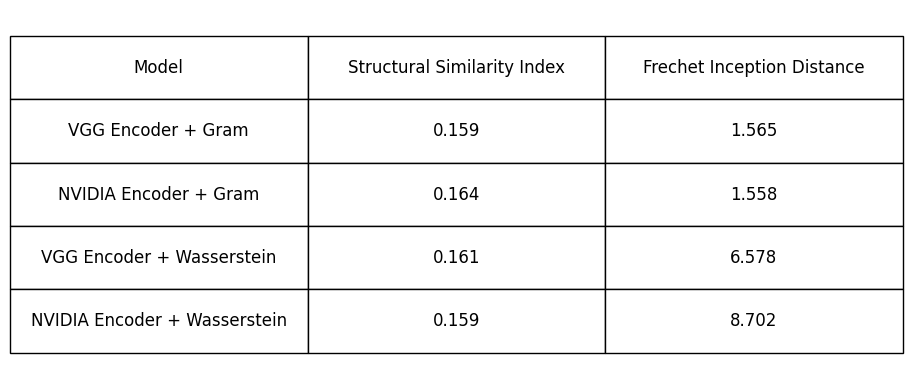

In [142]:
import matplotlib.pyplot as plt

data = [['Model', 'Structural Similarity Index', 'Frechet Inception Distance'],
 ['VGG Encoder + Gram', metrics["vgg_enc_gram"]["ssim"], metrics["vgg_enc_gram"]["fid"]],
 ['NVIDIA Encoder + Gram', metrics["nvidia_enc_gram"]["ssim"], metrics["nvidia_enc_gram"]["fid"]],
 ['VGG Encoder + Wasserstein', metrics["vgg_enc_wasserstein"]["ssim"], metrics["vgg_enc_wasserstein"]["fid"]],
 ['NVIDIA Encoder + Wasserstein', metrics["nvidia_enc_wasserstein"]["ssim"], metrics["nvidia_enc_wasserstein"]["fid"]]]

fig, ax = plt.subplots()
table = ax.table(cellText=data, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.8, 3.8)  # Adjust the table size

ax.axis('off')
plt.show()
